In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation + (In)Fidelity

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [6]:
def density_matrix_from_bloch_vector(bloch_vector):
   rho = 0.5 * (I+ bloch_vector[0]*X + bloch_vector[1]*Y + bloch_vector[2]*Z)
   return rho

In [7]:
def fidelity_function(a,b):
    fid = tf.linalg.trace(a @ b)
    return fid

In [8]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)
A = tf.stack([X_tf,Y_tf,Z_tf]) 

In [9]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   return infidelity 

In [10]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [11]:
sim_bknd=Aer.get_backend('aer_simulator')

In [12]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Noise Model

In [13]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [14]:
#BIT FLIP, PHASE FLIP AND BIT-PHASE FLIP ERROR

def flip_error(num_qubits, rho, error_type, p):

    E_0 = np.sqrt(1-p)*I
    if error_type == 'bit':
        E_1 = np.sqrt(p)*X
    if error_type == 'phase':
        E_1 = np.sqrt(p)*Z
    if error_type == 'bp':
        E_1 = np.sqrt(p)*Y
        
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

In [15]:
#GENERAL PAULI ERROR (generalizes and allows to combine the flip errors)

def g_pauli_error(num_qubits, rho, p_0, p_1, p_2, p_3):
    
    E_0 = np.sqrt(p_0)*I
    E_1 = np.sqrt(p_1)*X
    E_2 = np.sqrt(p_2)*Y
    E_3 = np.sqrt(p_3)*Z
    
    rho_with_gpauli_error = sum_element(rho, E_0)+sum_element(rho, E_1)+sum_element(rho, E_2)+sum_element(rho, E_3)
    
    return rho_with_gpauli_error

In [16]:
# DEPOLARIZING ERROR

def depolar_error(num_qubits, rho, p):
    
    rho_with_dep_error = p*I/2 + (1-p)*rho

    return rho_with_dep_error

In [17]:
#GENERAL AMPLITUDE DAMPING ERROR

def ampl_damp_error(num_qubits, rho, p, a):
  
    E_0 = np.sqrt(p)*np.array([[1, 0], [0, np.sqrt(1-a)]])
    E_1 = np.sqrt(p)*np.array([[0, np.sqrt(a)], [0, 0]])
    E_2 = np.sqrt(1-p)*np.array([[np.sqrt(1-a), 0], [0, 1]])
    E_3 = np.sqrt(1-p)*np.array([[0, 0], [np.sqrt(a), 0]])
    
    rho_with_ad_error = sum_element(rho, E_0)+sum_element(rho, E_1)+sum_element(rho, E_2)+sum_element(rho, E_3)

    return rho_with_ad_error

## Printing Bloch spheres

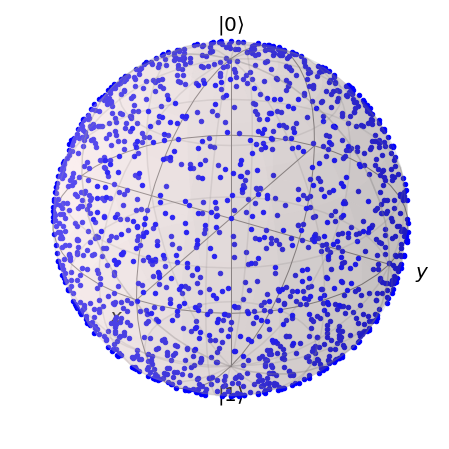

In [18]:
# GENERATE DATA
data = generate_Haar_data(1, 1500)
#COMPUTE NOISE FREE DENSITY MATRIX
density_matrix_noise_free = [*map(get_density_matrix, data)]
#COMPUTE BLOCH VECTOR NOISE FREE
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

#print Haar distribution
Bloch_sphere(bloch_vectors_noise_free)

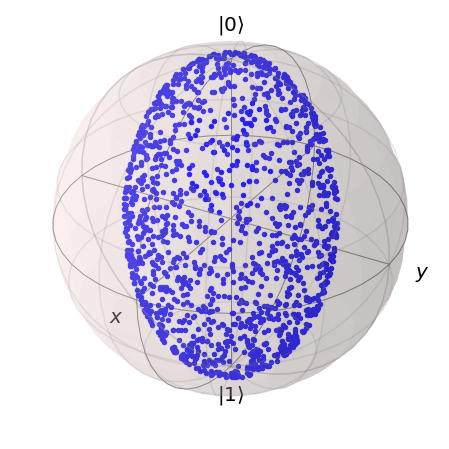

In [19]:
#APPLY ERROR (in this case phase error with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)


#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
Bloch_sphere(bloch_vectors_with_noise)

## Regression Problem

In [20]:
# GENERATE DATA
data = generate_Haar_data(1, 100)
#COMPUTE NOISE FREE DENSITY MATRIX
density_matrix_noise_free = [*map(get_density_matrix, data)]
#COMPUTE BLOCH VECTOR NOISE FREE
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES NOISE FREE
print("Density matrix noise free type:", density_matrix_noise_free[0].dtype)
#PRINT THE TYPE OF THE BLOCH VECTOR IN THE LISTS OF THE BLOCH VECTORS NOISE FREE
print("Bloch vector noise free type:", bloch_vectors_noise_free[0].dtype)

Density matrix noise free type: complex128
Bloch vector noise free type: float64


## Phase Flip Channel

In [21]:
#APPLY ERROR (in this case phase error with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: float64


In [83]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:3], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:3], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


### MSE

In [91]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
  ])

In [92]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3359 - val_loss: 0.3666
Epoch 2/200
1/1 [==============================] - 0s 87ms/step - loss: 0.3186 - val_loss: 0.3633
Epoch 3/200
1/1 [==============================] - 0s 93ms/step - loss: 0.3021 - val_loss: 0.3603
Epoch 4/200
1/1 [==============================] - 0s 86ms/step - loss: 0.2862 - val_loss: 0.3574
Epoch 5/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2708 - val_loss: 0.3547
Epoch 6/200
1/1 [==============================] - 0s 89ms/step - loss: 0.2562 - val_loss: 0.3523
Epoch 7/200
1/1 [==============================] - 0s 94ms/step - loss: 0.2423 - val_loss: 0.3500
Epoch 8/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2291 - val_loss: 0.3479
Epoch 9/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2166 - val_loss: 0.3459
Epoch 10/200
1/1 [==============================] - 0s 89ms/step - loss: 0.2047 - val_loss: 0.3440
Epoch 11/200
1/1 [===

Epoch 84/200
1/1 [==============================] - 0s 85ms/step - loss: 0.0011 - val_loss: 0.2630
Epoch 85/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0010 - val_loss: 0.2623
Epoch 86/200
1/1 [==============================] - 0s 77ms/step - loss: 9.6132e-04 - val_loss: 0.2616
Epoch 87/200
1/1 [==============================] - 0s 80ms/step - loss: 8.7769e-04 - val_loss: 0.2609
Epoch 88/200
1/1 [==============================] - 0s 77ms/step - loss: 8.0454e-04 - val_loss: 0.2602
Epoch 89/200
1/1 [==============================] - 0s 81ms/step - loss: 7.3381e-04 - val_loss: 0.2595
Epoch 90/200
1/1 [==============================] - 0s 80ms/step - loss: 6.6406e-04 - val_loss: 0.2588
Epoch 91/200
1/1 [==============================] - 0s 84ms/step - loss: 5.9587e-04 - val_loss: 0.2580
Epoch 92/200
1/1 [==============================] - 0s 85ms/step - loss: 5.3072e-04 - val_loss: 0.2573
Epoch 93/200
1/1 [==============================] - 0s 85ms/step - loss: 4.6887e-

Epoch 163/200
1/1 [==============================] - 0s 83ms/step - loss: 1.5871e-07 - val_loss: 0.2475
Epoch 164/200
1/1 [==============================] - 0s 81ms/step - loss: 1.3324e-07 - val_loss: 0.2475
Epoch 165/200
1/1 [==============================] - 0s 81ms/step - loss: 1.1141e-07 - val_loss: 0.2475
Epoch 166/200
1/1 [==============================] - 0s 83ms/step - loss: 9.3015e-08 - val_loss: 0.2475
Epoch 167/200
1/1 [==============================] - 0s 75ms/step - loss: 7.7712e-08 - val_loss: 0.2475
Epoch 168/200
1/1 [==============================] - 0s 80ms/step - loss: 6.5122e-08 - val_loss: 0.2475
Epoch 169/200
1/1 [==============================] - 0s 83ms/step - loss: 5.4931e-08 - val_loss: 0.2475
Epoch 170/200
1/1 [==============================] - 0s 91ms/step - loss: 4.6724e-08 - val_loss: 0.2475
Epoch 171/200
1/1 [==============================] - 0s 85ms/step - loss: 4.0155e-08 - val_loss: 0.2475
Epoch 172/200
1/1 [==============================] - 0s 80ms/ste

In [93]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []
n_fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)
    
  den_mat_n = density_matrix_from_bloch_vector(x_test[i])
  den_mat_n = np.asarray(den_mat_n)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)
    
  n_fidelity = fidelity_function(den_mat_id, den_mat_n)
  n_fidelities.append(n_fidelity)

print(tf.math.reduce_mean(fidelities))
print(tf.math.reduce_mean(n_fidelities))

1/1 - 0s - loss: 0.1153 - 194ms/epoch - 194ms/step
tf.Tensor((0.7976610615561788+0j), shape=(), dtype=complex128)
tf.Tensor((0.7439263507534997+0j), shape=(), dtype=complex128)


### INF

In [94]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [95]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=300)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.4252 - val_loss: 0.3388
Epoch 2/300
1/1 [==============================] - 0s 109ms/step - loss: 0.3798 - val_loss: 0.3355
Epoch 3/300
1/1 [==============================] - 0s 101ms/step - loss: 0.3336 - val_loss: 0.3316
Epoch 4/300
1/1 [==============================] - 0s 88ms/step - loss: 0.2884 - val_loss: 0.3284
Epoch 5/300
1/1 [==============================] - 0s 89ms/step - loss: 0.2457 - val_loss: 0.3261
Epoch 6/300
1/1 [==============================] - 0s 81ms/step - loss: 0.2059 - val_loss: 0.3247
Epoch 7/300
1/1 [==============================] - 0s 83ms/step - loss: 0.1687 - val_loss: 0.3242
Epoch 8/300
1/1 [==============================] - 0s 86ms/step - loss: 0.1349 - val_loss: 0.3248
Epoch 9/300
1/1 [==============================] - 0s 91ms/step - loss: 0.1056 - val_loss: 0.3260
Epoch 10/300
1/1 [==============================] - 0s 94ms/step - loss: 0.0811 - val_loss: 0.3285
Epoch 11/300
1/1 [=

1/1 [==============================] - 0s 103ms/step - loss: 1.6034e-05 - val_loss: 0.2583
Epoch 83/300
1/1 [==============================] - 0s 103ms/step - loss: 1.7206e-05 - val_loss: 0.2582
Epoch 84/300
1/1 [==============================] - 0s 118ms/step - loss: 1.8676e-05 - val_loss: 0.2582
Epoch 85/300
1/1 [==============================] - 0s 103ms/step - loss: 2.0067e-05 - val_loss: 0.2582
Epoch 86/300
1/1 [==============================] - 0s 99ms/step - loss: 2.1199e-05 - val_loss: 0.2583
Epoch 87/300
1/1 [==============================] - 0s 110ms/step - loss: 2.1895e-05 - val_loss: 0.2583
Epoch 88/300
1/1 [==============================] - 0s 92ms/step - loss: 2.1994e-05 - val_loss: 0.2584
Epoch 89/300
1/1 [==============================] - 0s 88ms/step - loss: 2.1537e-05 - val_loss: 0.2585
Epoch 90/300
1/1 [==============================] - 0s 84ms/step - loss: 2.0464e-05 - val_loss: 0.2587
Epoch 91/300
1/1 [==============================] - 0s 84ms/step - loss: 1.8895e-

Epoch 161/300
1/1 [==============================] - 0s 94ms/step - loss: 5.9605e-08 - val_loss: 0.2615
Epoch 162/300
1/1 [==============================] - 0s 84ms/step - loss: 1.9868e-08 - val_loss: 0.2615
Epoch 163/300
1/1 [==============================] - 0s 96ms/step - loss: 3.9736e-08 - val_loss: 0.2615
Epoch 164/300
1/1 [==============================] - 0s 101ms/step - loss: 1.9868e-08 - val_loss: 0.2615
Epoch 165/300
1/1 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - val_loss: 0.2615
Epoch 166/300
1/1 [==============================] - 0s 83ms/step - loss: 1.9868e-08 - val_loss: 0.2615
Epoch 167/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0000e+00 - val_loss: 0.2615
Epoch 168/300
1/1 [==============================] - 0s 110ms/step - loss: 3.9736e-08 - val_loss: 0.2615
Epoch 169/300
1/1 [==============================] - 0s 104ms/step - loss: 0.0000e+00 - val_loss: 0.2615
Epoch 170/300
1/1 [==============================] - 0s 89ms

1/1 [==============================] - 0s 85ms/step - loss: 0.0000e+00 - val_loss: 0.2616
Epoch 240/300
1/1 [==============================] - 0s 88ms/step - loss: 3.9736e-08 - val_loss: 0.2616
Epoch 241/300
1/1 [==============================] - 0s 81ms/step - loss: 0.0000e+00 - val_loss: 0.2616
Epoch 242/300
1/1 [==============================] - 0s 80ms/step - loss: 3.9736e-08 - val_loss: 0.2616
Epoch 243/300
1/1 [==============================] - 0s 81ms/step - loss: 3.9736e-08 - val_loss: 0.2616
Epoch 244/300
1/1 [==============================] - 0s 78ms/step - loss: 0.0000e+00 - val_loss: 0.2616
Epoch 245/300
1/1 [==============================] - 0s 82ms/step - loss: 1.9868e-08 - val_loss: 0.2616
Epoch 246/300
1/1 [==============================] - 0s 82ms/step - loss: 0.0000e+00 - val_loss: 0.2616
Epoch 247/300
1/1 [==============================] - 0s 86ms/step - loss: 1.9868e-08 - val_loss: 0.2616
Epoch 248/300
1/1 [==============================] - 0s 86ms/step - loss: 0.00

In [96]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 0.1862 - 231ms/epoch - 231ms/step
tf.Tensor((0.8138487058878097+0j), shape=(), dtype=complex128)


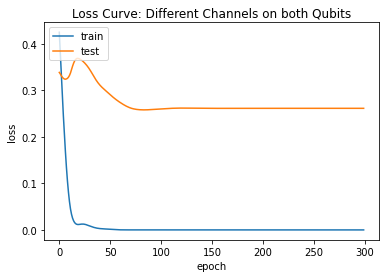

In [97]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Bit Flip Channel

In [73]:
#APPLY ERROR (in this case phase error with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'bit', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: float64


In [74]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


### MSE

In [75]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
  ])

In [76]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 70ms/step - loss: 0.3424 - val_loss: 0.3088
Epoch 2/200
5/5 [==============================] - 0s 24ms/step - loss: 0.2908 - val_loss: 0.2674
Epoch 3/200
5/5 [==============================] - 0s 25ms/step - loss: 0.2451 - val_loss: 0.2315
Epoch 4/200
5/5 [==============================] - 0s 26ms/step - loss: 0.2074 - val_loss: 0.2004
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1748 - val_loss: 0.1719
Epoch 6/200
5/5 [==============================] - 0s 22ms/step - loss: 0.1449 - val_loss: 0.1448
Epoch 7/200
5/5 [==============================] - 0s 24ms/step - loss: 0.1187 - val_loss: 0.1199
Epoch 8/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0945 - val_loss: 0.0963
Epoch 9/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0735 - val_loss: 0.0757
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0558 - val_loss: 0.0581
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 23ms/step - loss: 2.2565e-05 - val_loss: 3.0468e-04
Epoch 156/200
5/5 [==============================] - 0s 22ms/step - loss: 2.2385e-05 - val_loss: 3.0110e-04
Epoch 157/200
5/5 [==============================] - 0s 16ms/step - loss: 2.0944e-05 - val_loss: 3.1079e-04
Epoch 158/200
5/5 [==============================] - 0s 19ms/step - loss: 1.9784e-05 - val_loss: 3.0232e-04
Epoch 159/200
5/5 [==============================] - 0s 18ms/step - loss: 2.0995e-05 - val_loss: 2.9577e-04
Epoch 160/200
5/5 [==============================] - 0s 18ms/step - loss: 1.9898e-05 - val_loss: 3.0214e-04
Epoch 161/200
5/5 [==============================] - 0s 24ms/step - loss: 1.9069e-05 - val_loss: 3.0335e-04
Epoch 162/200
5/5 [==============================] - 0s 26ms/step - loss: 1.9090e-05 - val_loss: 2.9874e-04
Epoch 163/200
5/5 [==============================] - 0s 26ms/step - loss: 1.9323e-05 - val_loss: 3.0376e-04
Epoch 164/200
5/5 [=======================

In [77]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 6.0814e-05 - 230ms/epoch - 230ms/step
tf.Tensor((1.0000325631140117+0j), shape=(), dtype=complex128)


### INF

In [78]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
  ])

In [79]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 89ms/step - loss: 0.5284 - val_loss: 0.3830
Epoch 2/200
5/5 [==============================] - 0s 26ms/step - loss: 0.3850 - val_loss: 0.2731
Epoch 3/200
5/5 [==============================] - 0s 20ms/step - loss: 0.2725 - val_loss: 0.1705
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1775 - val_loss: 0.0927
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0990 - val_loss: 0.0561
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0522 - val_loss: 0.0366
Epoch 7/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0269 - val_loss: 0.0229
Epoch 8/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0133 - val_loss: 0.0163
Epoch 9/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0082 - val_loss: 0.0133
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0067 - val_loss: 0.0109
Epoch 11/200
5/5 [=

Epoch 80/200
5/5 [==============================] - 0s 20ms/step - loss: 3.8695e-05 - val_loss: 8.1720e-04
Epoch 81/200
5/5 [==============================] - 0s 22ms/step - loss: 3.6609e-05 - val_loss: 8.1981e-04
Epoch 82/200
5/5 [==============================] - 0s 23ms/step - loss: 3.6311e-05 - val_loss: 8.0763e-04
Epoch 83/200
5/5 [==============================] - 0s 18ms/step - loss: 3.4699e-05 - val_loss: 8.0807e-04
Epoch 84/200
5/5 [==============================] - 0s 21ms/step - loss: 3.3922e-05 - val_loss: 8.2304e-04
Epoch 85/200
5/5 [==============================] - 0s 24ms/step - loss: 3.3770e-05 - val_loss: 8.0761e-04
Epoch 86/200
5/5 [==============================] - 0s 26ms/step - loss: 3.2669e-05 - val_loss: 7.9932e-04
Epoch 87/200
5/5 [==============================] - 0s 22ms/step - loss: 3.1018e-05 - val_loss: 8.0714e-04
Epoch 88/200
5/5 [==============================] - 0s 20ms/step - loss: 3.0236e-05 - val_loss: 8.0805e-04
Epoch 89/200
5/5 [===================

5/5 [==============================] - 0s 22ms/step - loss: 9.1684e-06 - val_loss: 7.7200e-04
Epoch 157/200
5/5 [==============================] - 0s 22ms/step - loss: 7.5865e-06 - val_loss: 7.6358e-04
Epoch 158/200
5/5 [==============================] - 0s 20ms/step - loss: 8.2207e-06 - val_loss: 7.6253e-04
Epoch 159/200
5/5 [==============================] - 0s 20ms/step - loss: 8.0645e-06 - val_loss: 7.7379e-04
Epoch 160/200
5/5 [==============================] - 0s 22ms/step - loss: 7.7927e-06 - val_loss: 7.6513e-04
Epoch 161/200
5/5 [==============================] - 0s 24ms/step - loss: 7.1657e-06 - val_loss: 7.6045e-04
Epoch 162/200
5/5 [==============================] - 0s 24ms/step - loss: 7.4637e-06 - val_loss: 7.6707e-04
Epoch 163/200
5/5 [==============================] - 0s 18ms/step - loss: 7.1418e-06 - val_loss: 7.7039e-04
Epoch 164/200
5/5 [==============================] - 0s 20ms/step - loss: 7.6079e-06 - val_loss: 7.5878e-04
Epoch 165/200
5/5 [=======================

In [80]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 2.0944e-04 - 243ms/epoch - 243ms/step
tf.Tensor((0.9997905494500658+0j), shape=(), dtype=complex128)


## Bit-Phase Flip Channel

In [39]:
#APPLY ERROR (in this case phase error with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'bp', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: float64


In [40]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:40], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:40], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


### MSE

In [41]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
  ])

In [42]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
4/4 [==============================] - 1s 94ms/step - loss: 0.3371 - val_loss: 0.3161
Epoch 2/200
4/4 [==============================] - 0s 35ms/step - loss: 0.2990 - val_loss: 0.2856
Epoch 3/200
4/4 [==============================] - 0s 28ms/step - loss: 0.2652 - val_loss: 0.2577
Epoch 4/200
4/4 [==============================] - 0s 29ms/step - loss: 0.2350 - val_loss: 0.2309
Epoch 5/200
4/4 [==============================] - 0s 26ms/step - loss: 0.2052 - val_loss: 0.2052
Epoch 6/200
4/4 [==============================] - 0s 22ms/step - loss: 0.1764 - val_loss: 0.1802
Epoch 7/200
4/4 [==============================] - 0s 27ms/step - loss: 0.1500 - val_loss: 0.1561
Epoch 8/200
4/4 [==============================] - 0s 24ms/step - loss: 0.1237 - val_loss: 0.1328
Epoch 9/200
4/4 [==============================] - 0s 24ms/step - loss: 0.1004 - val_loss: 0.1112
Epoch 10/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0795 - val_loss: 0.0919
Epoch 11/200
4/4 [=

4/4 [==============================] - 0s 27ms/step - loss: 2.0409e-05 - val_loss: 6.5456e-04
Epoch 158/200
4/4 [==============================] - 0s 21ms/step - loss: 1.9874e-05 - val_loss: 6.5570e-04
Epoch 159/200
4/4 [==============================] - 0s 24ms/step - loss: 1.9676e-05 - val_loss: 6.6056e-04
Epoch 160/200
4/4 [==============================] - 0s 24ms/step - loss: 1.9157e-05 - val_loss: 6.4933e-04
Epoch 161/200
4/4 [==============================] - 0s 24ms/step - loss: 1.9670e-05 - val_loss: 6.4883e-04
Epoch 162/200
4/4 [==============================] - 0s 24ms/step - loss: 1.9118e-05 - val_loss: 6.5419e-04
Epoch 163/200
4/4 [==============================] - 0s 27ms/step - loss: 1.8702e-05 - val_loss: 6.4584e-04
Epoch 164/200
4/4 [==============================] - 0s 27ms/step - loss: 1.8848e-05 - val_loss: 6.4217e-04
Epoch 165/200
4/4 [==============================] - 0s 24ms/step - loss: 1.7829e-05 - val_loss: 6.5356e-04
Epoch 166/200
4/4 [=======================

In [43]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 8.3546e-05 - 203ms/epoch - 203ms/step
tf.Tensor((1.0027990543824299+0j), shape=(), dtype=complex128)


### INF

In [44]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
  ])

In [45]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
4/4 [==============================] - 2s 116ms/step - loss: 0.4192 - val_loss: 0.3287
Epoch 2/200
4/4 [==============================] - 0s 26ms/step - loss: 0.2070 - val_loss: 0.1502
Epoch 3/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0862 - val_loss: 0.0565
Epoch 4/200
4/4 [==============================] - 0s 30ms/step - loss: 0.0379 - val_loss: 0.0448
Epoch 5/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0263 - val_loss: 0.0319
Epoch 6/200
4/4 [==============================] - 0s 29ms/step - loss: 0.0168 - val_loss: 0.0183
Epoch 7/200
4/4 [==============================] - 0s 25ms/step - loss: 0.0100 - val_loss: 0.0115
Epoch 8/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 9/200
4/4 [==============================] - 0s 29ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 10/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 11/200
4/4 [

4/4 [==============================] - 0s 27ms/step - loss: 6.4731e-06 - val_loss: 0.0021
Epoch 161/200
4/4 [==============================] - 0s 29ms/step - loss: 6.3762e-06 - val_loss: 0.0022
Epoch 162/200
4/4 [==============================] - 0s 32ms/step - loss: 5.9411e-06 - val_loss: 0.0022
Epoch 163/200
4/4 [==============================] - 0s 29ms/step - loss: 6.0990e-06 - val_loss: 0.0021
Epoch 164/200
4/4 [==============================] - 0s 27ms/step - loss: 6.1244e-06 - val_loss: 0.0022
Epoch 165/200
4/4 [==============================] - 0s 27ms/step - loss: 6.2883e-06 - val_loss: 0.0022
Epoch 166/200
4/4 [==============================] - 0s 29ms/step - loss: 5.8562e-06 - val_loss: 0.0021
Epoch 167/200
4/4 [==============================] - 0s 27ms/step - loss: 5.8606e-06 - val_loss: 0.0021
Epoch 168/200
4/4 [==============================] - 0s 35ms/step - loss: 5.3629e-06 - val_loss: 0.0022
Epoch 169/200
4/4 [==============================] - 0s 32ms/step - loss: 5.57

In [46]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 0.0016 - 237ms/epoch - 237ms/step
tf.Tensor((0.9984285433625457+0j), shape=(), dtype=complex128)


## General Pauli Channel

In [81]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = g_pauli_error(1, density_matrix_noise_free[i], 0.7, 0.1, 0.1, 0.1)
    density_matrix_with_noise.append(single_data_with_noise)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [82]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

### MSE

In [83]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
  ])

In [84]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 65ms/step - loss: 0.3373 - val_loss: 0.3135
Epoch 2/200
5/5 [==============================] - 0s 21ms/step - loss: 0.2960 - val_loss: 0.2792
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2603 - val_loss: 0.2469
Epoch 4/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2279 - val_loss: 0.2180
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1977 - val_loss: 0.1906
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1680 - val_loss: 0.1631
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.1396 - val_loss: 0.1362
Epoch 8/200
5/5 [==============================] - 0s 21ms/step - loss: 0.1115 - val_loss: 0.1103
Epoch 9/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0862 - val_loss: 0.0866
Epoch 10/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0638 - val_loss: 0.0653
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 22ms/step - loss: 2.1710e-05 - val_loss: 4.0290e-04
Epoch 156/200
5/5 [==============================] - 0s 18ms/step - loss: 2.1422e-05 - val_loss: 4.0060e-04
Epoch 157/200
5/5 [==============================] - 0s 18ms/step - loss: 2.1158e-05 - val_loss: 4.0272e-04
Epoch 158/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0857e-05 - val_loss: 4.0221e-04
Epoch 159/200
5/5 [==============================] - 0s 20ms/step - loss: 2.0734e-05 - val_loss: 3.9679e-04
Epoch 160/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0117e-05 - val_loss: 3.9679e-04
Epoch 161/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0829e-05 - val_loss: 4.0410e-04
Epoch 162/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9668e-05 - val_loss: 3.9766e-04
Epoch 163/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9701e-05 - val_loss: 3.9876e-04
Epoch 164/200
5/5 [=======================

In [85]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 1.8501e-04 - 193ms/epoch - 193ms/step
tf.Tensor((0.998422795183377+0j), shape=(), dtype=complex128)


### INF

In [86]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
  ])

In [87]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 89ms/step - loss: 0.2614 - val_loss: 0.1932
Epoch 2/200
5/5 [==============================] - 0s 23ms/step - loss: 0.1053 - val_loss: 0.0749
Epoch 3/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0348 - val_loss: 0.0379
Epoch 4/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0196 - val_loss: 0.0233
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 6/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 7/200
5/5 [==============================] - 0s 23ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 8/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 9/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 10/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 11/200
5/5 [=

Epoch 80/200
5/5 [==============================] - 0s 22ms/step - loss: 2.8939e-05 - val_loss: 8.6880e-04
Epoch 81/200
5/5 [==============================] - 0s 24ms/step - loss: 2.6475e-05 - val_loss: 8.6611e-04
Epoch 82/200
5/5 [==============================] - 0s 24ms/step - loss: 2.6577e-05 - val_loss: 8.6052e-04
Epoch 83/200
5/5 [==============================] - 0s 24ms/step - loss: 2.5494e-05 - val_loss: 8.4603e-04
Epoch 84/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4980e-05 - val_loss: 8.6161e-04
Epoch 85/200
5/5 [==============================] - 0s 18ms/step - loss: 2.4319e-05 - val_loss: 8.5469e-04
Epoch 86/200
5/5 [==============================] - 0s 18ms/step - loss: 2.3416e-05 - val_loss: 8.5253e-04
Epoch 87/200
5/5 [==============================] - 0s 19ms/step - loss: 2.3993e-05 - val_loss: 8.5657e-04
Epoch 88/200
5/5 [==============================] - 0s 18ms/step - loss: 2.5094e-05 - val_loss: 8.5710e-04
Epoch 89/200
5/5 [===================

5/5 [==============================] - 0s 20ms/step - loss: 4.3988e-06 - val_loss: 8.1232e-04
Epoch 157/200
5/5 [==============================] - 0s 20ms/step - loss: 4.3011e-06 - val_loss: 8.0965e-04
Epoch 158/200
5/5 [==============================] - 0s 23ms/step - loss: 3.9411e-06 - val_loss: 8.0774e-04
Epoch 159/200
5/5 [==============================] - 0s 22ms/step - loss: 4.1473e-06 - val_loss: 8.0569e-04
Epoch 160/200
5/5 [==============================] - 0s 20ms/step - loss: 3.6967e-06 - val_loss: 8.1325e-04
Epoch 161/200
5/5 [==============================] - 0s 20ms/step - loss: 3.9673e-06 - val_loss: 8.0434e-04
Epoch 162/200
5/5 [==============================] - 0s 20ms/step - loss: 3.6788e-06 - val_loss: 8.1064e-04
Epoch 163/200
5/5 [==============================] - 0s 24ms/step - loss: 3.7503e-06 - val_loss: 8.1342e-04
Epoch 164/200
5/5 [==============================] - 0s 24ms/step - loss: 3.9577e-06 - val_loss: 7.9748e-04
Epoch 165/200
5/5 [=======================

In [88]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 5.4007e-04 - 256ms/epoch - 256ms/step
tf.Tensor((0.9994599367812246+0j), shape=(), dtype=complex128)


## Amplitude Damping Channel

In [89]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = ampl_damp_error(1, density_matrix_noise_free[i], 0.5, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [90]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

### MSE

In [91]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)), 
  tf.keras.layers.Dense(64, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),                                  
  tf.keras.layers.Dense(3)
  ])

In [92]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [93]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val,y_val),batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 69ms/step - loss: 0.3438 - val_loss: 0.3112
Epoch 2/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2880 - val_loss: 0.2647
Epoch 3/200
5/5 [==============================] - 0s 18ms/step - loss: 0.2401 - val_loss: 0.2229
Epoch 4/200
5/5 [==============================] - 0s 21ms/step - loss: 0.1980 - val_loss: 0.1859
Epoch 5/200
5/5 [==============================] - 0s 19ms/step - loss: 0.1600 - val_loss: 0.1528
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1266 - val_loss: 0.1227
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0976 - val_loss: 0.0962
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0724 - val_loss: 0.0727
Epoch 9/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0513 - val_loss: 0.0532
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0351 - val_loss: 0.0373
Epoch 11/200
5/5 [=

Epoch 80/200
5/5 [==============================] - 0s 22ms/step - loss: 8.5996e-05 - val_loss: 6.4531e-04
Epoch 81/200
5/5 [==============================] - 0s 22ms/step - loss: 8.3370e-05 - val_loss: 6.3930e-04
Epoch 82/200
5/5 [==============================] - 0s 22ms/step - loss: 8.0857e-05 - val_loss: 6.4307e-04
Epoch 83/200
5/5 [==============================] - 0s 20ms/step - loss: 8.0033e-05 - val_loss: 6.4448e-04
Epoch 84/200
5/5 [==============================] - 0s 22ms/step - loss: 8.1206e-05 - val_loss: 6.3777e-04
Epoch 85/200
5/5 [==============================] - 0s 20ms/step - loss: 7.8943e-05 - val_loss: 6.2718e-04
Epoch 86/200
5/5 [==============================] - 0s 22ms/step - loss: 7.7014e-05 - val_loss: 6.2832e-04
Epoch 87/200
5/5 [==============================] - 0s 19ms/step - loss: 7.2998e-05 - val_loss: 6.2025e-04
Epoch 88/200
5/5 [==============================] - 0s 20ms/step - loss: 7.5034e-05 - val_loss: 6.0144e-04
Epoch 89/200
5/5 [===================

5/5 [==============================] - 0s 26ms/step - loss: 2.6931e-05 - val_loss: 4.8200e-04
Epoch 157/200
5/5 [==============================] - 0s 18ms/step - loss: 2.5278e-05 - val_loss: 4.9928e-04
Epoch 158/200
5/5 [==============================] - 0s 21ms/step - loss: 2.4084e-05 - val_loss: 4.8646e-04
Epoch 159/200
5/5 [==============================] - 0s 20ms/step - loss: 2.5674e-05 - val_loss: 4.8431e-04
Epoch 160/200
5/5 [==============================] - 0s 19ms/step - loss: 2.2595e-05 - val_loss: 4.8528e-04
Epoch 161/200
5/5 [==============================] - 0s 20ms/step - loss: 2.3735e-05 - val_loss: 4.8532e-04
Epoch 162/200
5/5 [==============================] - 0s 20ms/step - loss: 2.3329e-05 - val_loss: 4.8252e-04
Epoch 163/200
5/5 [==============================] - 0s 20ms/step - loss: 2.3111e-05 - val_loss: 4.8912e-04
Epoch 164/200
5/5 [==============================] - 0s 20ms/step - loss: 2.2826e-05 - val_loss: 4.7459e-04
Epoch 165/200
5/5 [=======================

In [94]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 1.4444e-04 - 217ms/epoch - 217ms/step
tf.Tensor((0.9994821667701119+0j), shape=(), dtype=complex128)


### INF

In [95]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
  ])

In [96]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 94ms/step - loss: 0.2476 - val_loss: 0.1519
Epoch 2/200
5/5 [==============================] - 0s 26ms/step - loss: 0.1033 - val_loss: 0.0519
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0409 - val_loss: 0.0232
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0260 - val_loss: 0.0179
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0174 - val_loss: 0.0107
Epoch 6/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 7/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 8/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 9/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 11/200
5/5 [=

Epoch 79/200
5/5 [==============================] - 0s 24ms/step - loss: 1.9443e-05 - val_loss: 4.6022e-04
Epoch 80/200
5/5 [==============================] - 0s 20ms/step - loss: 1.8431e-05 - val_loss: 4.6814e-04
Epoch 81/200
5/5 [==============================] - 0s 16ms/step - loss: 1.8625e-05 - val_loss: 4.5809e-04
Epoch 82/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6893e-05 - val_loss: 4.6495e-04
Epoch 83/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6376e-05 - val_loss: 4.6616e-04
Epoch 84/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6605e-05 - val_loss: 4.5626e-04
Epoch 85/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5475e-05 - val_loss: 4.5783e-04
Epoch 86/200
5/5 [==============================] - 0s 19ms/step - loss: 1.5235e-05 - val_loss: 4.6536e-04
Epoch 87/200
5/5 [==============================] - 0s 24ms/step - loss: 1.4232e-05 - val_loss: 4.5873e-04
Epoch 88/200
5/5 [===================

5/5 [==============================] - 0s 22ms/step - loss: 3.0458e-06 - val_loss: 4.4082e-04
Epoch 156/200
5/5 [==============================] - 0s 22ms/step - loss: 2.8837e-06 - val_loss: 4.3987e-04
Epoch 157/200
5/5 [==============================] - 0s 22ms/step - loss: 2.9290e-06 - val_loss: 4.4086e-04
Epoch 158/200
5/5 [==============================] - 0s 21ms/step - loss: 3.0744e-06 - val_loss: 4.3855e-04
Epoch 159/200
5/5 [==============================] - 0s 20ms/step - loss: 3.2616e-06 - val_loss: 4.3779e-04
Epoch 160/200
5/5 [==============================] - 0s 22ms/step - loss: 2.7871e-06 - val_loss: 4.3926e-04
Epoch 161/200
5/5 [==============================] - 0s 21ms/step - loss: 2.7001e-06 - val_loss: 4.3930e-04
Epoch 162/200
5/5 [==============================] - 0s 22ms/step - loss: 2.8992e-06 - val_loss: 4.4083e-04
Epoch 163/200
5/5 [==============================] - 0s 20ms/step - loss: 2.8586e-06 - val_loss: 4.3745e-04
Epoch 164/200
5/5 [=======================

In [97]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 2.9617e-04 - 258ms/epoch - 258ms/step
tf.Tensor((0.9997038259280812+0j), shape=(), dtype=complex128)


## Depolarizing Channel

In [98]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = depolar_error(1, density_matrix_noise_free[i], 0.3)
    density_matrix_with_noise.append(single_data_with_noise)
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [99]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

### MSE

In [100]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)), 
  tf.keras.layers.Dense(64, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),                                  
  tf.keras.layers.Dense(3)
  ])

In [101]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [102]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val,y_val),batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 94ms/step - loss: 0.3186 - val_loss: 0.2986
Epoch 2/200
5/5 [==============================] - 0s 18ms/step - loss: 0.2720 - val_loss: 0.2576
Epoch 3/200
5/5 [==============================] - 0s 40ms/step - loss: 0.2315 - val_loss: 0.2189
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1948 - val_loss: 0.1846
Epoch 5/200
5/5 [==============================] - 0s 22ms/step - loss: 0.1607 - val_loss: 0.1540
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1298 - val_loss: 0.1264
Epoch 7/200
5/5 [==============================] - 0s 28ms/step - loss: 0.1020 - val_loss: 0.1030
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0792 - val_loss: 0.0827
Epoch 9/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0603 - val_loss: 0.0656
Epoch 10/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0462 - val_loss: 0.0507
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 20ms/step - loss: 1.4353e-05 - val_loss: 3.5353e-04
Epoch 156/200
5/5 [==============================] - 0s 20ms/step - loss: 1.4560e-05 - val_loss: 3.4481e-04
Epoch 157/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4067e-05 - val_loss: 3.4369e-04
Epoch 158/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5380e-05 - val_loss: 3.5716e-04
Epoch 159/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5411e-05 - val_loss: 3.3915e-04
Epoch 160/200
5/5 [==============================] - 0s 24ms/step - loss: 1.4250e-05 - val_loss: 3.4840e-04
Epoch 161/200
5/5 [==============================] - 0s 26ms/step - loss: 1.4493e-05 - val_loss: 3.4080e-04
Epoch 162/200
5/5 [==============================] - 0s 20ms/step - loss: 1.3926e-05 - val_loss: 3.3521e-04
Epoch 163/200
5/5 [==============================] - 0s 26ms/step - loss: 1.3042e-05 - val_loss: 3.4511e-04
Epoch 164/200
5/5 [=======================

In [103]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 7.5641e-05 - 191ms/epoch - 191ms/step
tf.Tensor((0.9987502039157767+0j), shape=(), dtype=complex128)


### INF

In [104]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
  ])

In [105]:
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 79ms/step - loss: 0.4646 - val_loss: 0.4060
Epoch 2/200
5/5 [==============================] - 0s 26ms/step - loss: 0.2293 - val_loss: 0.2055
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.1051 - val_loss: 0.0756
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0364 - val_loss: 0.0448
Epoch 5/200
5/5 [==============================] - 0s 23ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 6/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 7/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 8/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 9/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 10/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 20ms/step - loss: 1.2746e-05 - val_loss: 7.1886e-04
Epoch 157/200
5/5 [==============================] - 0s 25ms/step - loss: 1.2732e-05 - val_loss: 7.1062e-04
Epoch 158/200
5/5 [==============================] - 0s 30ms/step - loss: 1.2368e-05 - val_loss: 7.1734e-04
Epoch 159/200
5/5 [==============================] - 0s 34ms/step - loss: 1.2380e-05 - val_loss: 7.1234e-04
Epoch 160/200
5/5 [==============================] - 0s 44ms/step - loss: 1.1793e-05 - val_loss: 7.0487e-04
Epoch 161/200
5/5 [==============================] - 0s 24ms/step - loss: 1.1674e-05 - val_loss: 7.1256e-04
Epoch 162/200
5/5 [==============================] - 0s 20ms/step - loss: 1.1437e-05 - val_loss: 7.1244e-04
Epoch 163/200
5/5 [==============================] - 0s 20ms/step - loss: 1.1330e-05 - val_loss: 7.0617e-04
Epoch 164/200
5/5 [==============================] - 0s 20ms/step - loss: 1.1412e-05 - val_loss: 7.0941e-04
Epoch 165/200
5/5 [=======================

In [106]:
score = model.evaluate(x_test,  y_test, verbose=2)

#save the model predictions in a tensor
y_prediction = model(x_test)

#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)

fidelities = []

for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)


  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

print(tf.math.reduce_mean(fidelities))

1/1 - 0s - loss: 6.1127e-04 - 274ms/epoch - 274ms/step
tf.Tensor((0.9993887449341811+0j), shape=(), dtype=complex128)
